In [39]:
import torch

import cv2

import torch.nn.functional  as F

import torchvision

import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

from torchvision import models

from PIL import Image

In [40]:
# Load pretrained ResNet18 (fine-tuned one if available)

model = models.resnet18(pretrained = True)

model.eval()

/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
# Target the final convolutional layer in ResNet18

target_layer = model.layer4[-1]

In [42]:
# Load sample image from local

img = Image.open("Husky Love.jpg").convert("RGB")  # Convert to grayscale


In [43]:
# Preprocess to match model expectations

transform = transforms.Compose([

    transforms.Resize((224,224)),

    transforms.ToTensor(),

    transforms.Normalize(

                mean=[0.485, 0.456, 0.406],  # ImageNet stats

                std=[0.229, 0.224, 0.225]

    )
])

input_tensor = transform(img).unsqueeze(0)  # Shape: [1, 3, 224, 224]

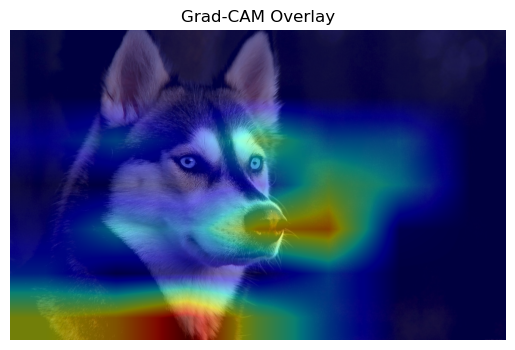

In [44]:
class GradCam:

    def __init__(self, model, target_layer):

        self.model = model.eval()

        self.target_layer = self._get_layer(target_layer)


        self.gradients = None

        self.activations = None


        # Hook for gradients (backward)

        self.target_layer.register_full_backward_hook(self._save_gradient)

        # Hook for activations (forward)

        self.target_layer.register_forward_hook(self._save_activation)

    
    def _get_layer(self, target_layer):

        # Traverse model to fetch target layer (supports strings like 'layer4')

        layer = self.model

        for name in target_layer.split('.'):

            layer = getattr(layer, name)

        return layer
    

    def _save_gradient(self, module, grad_input, grad_output):

        self.gradients = grad_output[0]  # Save gradient of output wrt layer

    def _save_activation(self, module, input, output):
         

        self.activations = output # Save forward activation maps
    
    def generate(self, input_tensor, target_class = None):

        self.model.zero_grad()
         
        output = self.model(input_tensor)


        if target_class is None:
            
            target_class = output.argmax(dim=1).item()

        target = output[0, target_class]

        target.backward()


        gradients = self.gradients[0]  # [C, H, W]

        activations = self.activations[0] # [C, H, W]


        weights = gradients.mean(dim=(1, 2)) # Global average pooling: [C]


        # Weighted combination of activations

        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)


        for i, w in enumerate(weights):

            cam += w * activations[i]

        cam = F.relu(cam) # Apply ReLU

        cam  = cam - cam.min()

        cam = cam / cam.max()

        cam  = cam.cpu().detach().numpy()


        return cam


    def overlay(self, img_pil, cam, alpha=0.5):

        width, height = img_pil.size

        img_np = np.array(img_pil.resize((width, height)))/ 255.0

        cam_resized  = cv2.resize(cam, (width, height))

        heatmap = plt.cm.jet(cam_resized)[...,:3]

        overlay = alpha * img_np + (1 - alpha) * heatmap

        overlay = np.clip(overlay, 0, 1)

        return overlay
    
    
    
    
gradcam = GradCam(model, target_layer='layer4')

cam = gradcam.generate(input_tensor, target_class=243)  # Optional: use argmax if None

overlay = gradcam.overlay(img, cam)


plt.imshow(overlay)

plt.axis('off')

plt.title("Grad-CAM Overlay")

plt.show()